# XTern Class of 2020: Data Science Work Sample Assessment
My goal is to draw some interesting conclusions from the scooter data, and perhaps come up with a solid gameplan for what to do with it!

One of my assumptions is that the bus can charge the scooters while it is driving. This is a rather efficient way for the bus to work, so that it can go from scooter to scooter and pick up/drop off scooters while still charging some.

Another assumption that I'm making is that the scooter's batteries charge in linear time. This is untrue - modern lithium-ion batteries charge roughly in exponential time - but it helps computationally to assume this, so that we don't have to consider odd decimal values for scooters that have non-zero or non-full charge.

I also assume that the relative coordinates are given in units of miles. This makes sense given that the bus's speed is given in mi/h.

One other assumption that I make is that the bus has infinite charging power and doesn't need to stop for gas or to let the driver have a break. I will challenge this assumption by reducing the bus's efficiency and requiring it to stop for gas near the end of this notebook.

### General dependencies

In [0]:
import io
from time import time

from google.colab import files
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

### Import dataset

In [3]:
dataset = files.upload()["2019-XTern- Work Sample Assessment Data Science-DS.csv"]
df = pd.read_csv(io.BytesIO(dataset))

Saving 2019-XTern- Work Sample Assessment Data Science-DS.csv to 2019-XTern- Work Sample Assessment Data Science-DS.csv


In [4]:
n_samples = len(df)
print(f"There are {n_samples} records in the scooter dataset with these columns:")
print(", ".join(df.columns))

There are 25668 records in the scooter dataset with these columns:
scooter_id, xcoordinate, ycoordinate, power_level


### Simple visualization of coordinates
Here we see a plot of all the scooter's locations, and all the scooter's locations paired with the bus's starting point. I kept the gridlines at an equal distance for both plots, to show just how far away the bus must start.

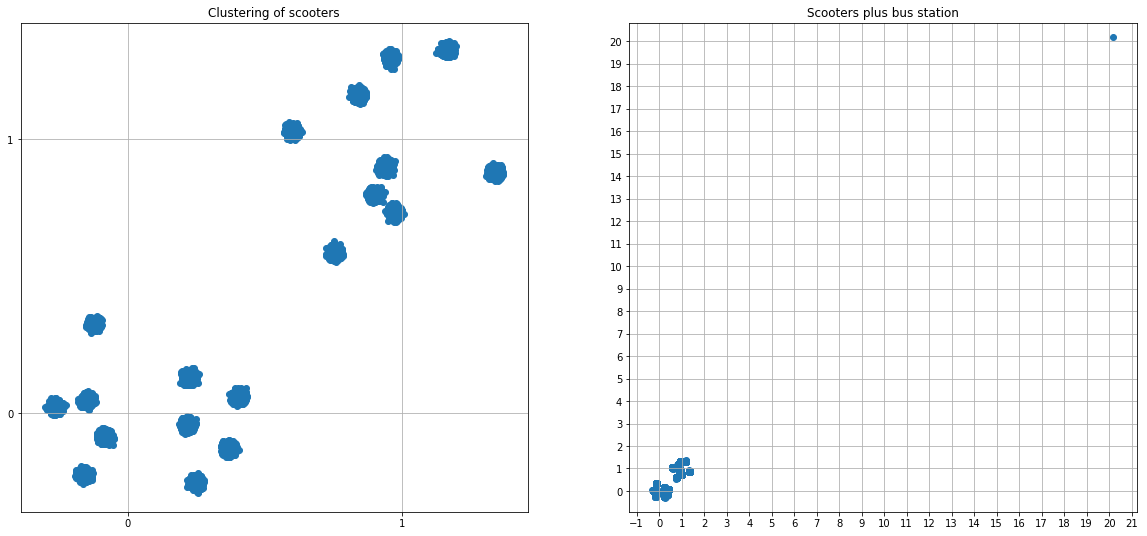

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9))

gridlines = np.arange(-1, 22, 1)

ax1.scatter(df.xcoordinate, df.ycoordinate, marker="o")
ax1.grid(True)
ax1.set_xticks(gridlines)
ax1.set_yticks(gridlines)
ax1.set_title("Clustering of scooters")
ax1.axis("equal")

ax2.scatter(df.xcoordinate.append(pd.DataFrame([20.19])), df.ycoordinate.append(pd.DataFrame([20.19])))
ax2.grid(True)
ax2.set_xticks(gridlines)
ax2.set_yticks(gridlines)
ax2.set_title("Scooters plus bus station")
ax2.axis("equal")

plt.show()
print()

### Approach 1: Gaussian Mixture Model clustering
My first thought was to use a clustering algorithm to collect the scooters into distinct groups. It is clear from the above plot that there are 19 mostly separate clusters throughout the city. I used a Gaussian Mixture Model instead of something simpler like k-means because upon further inspection, each cluster appeared to be distributed like a Gaussian with equal x and y standard distribution.

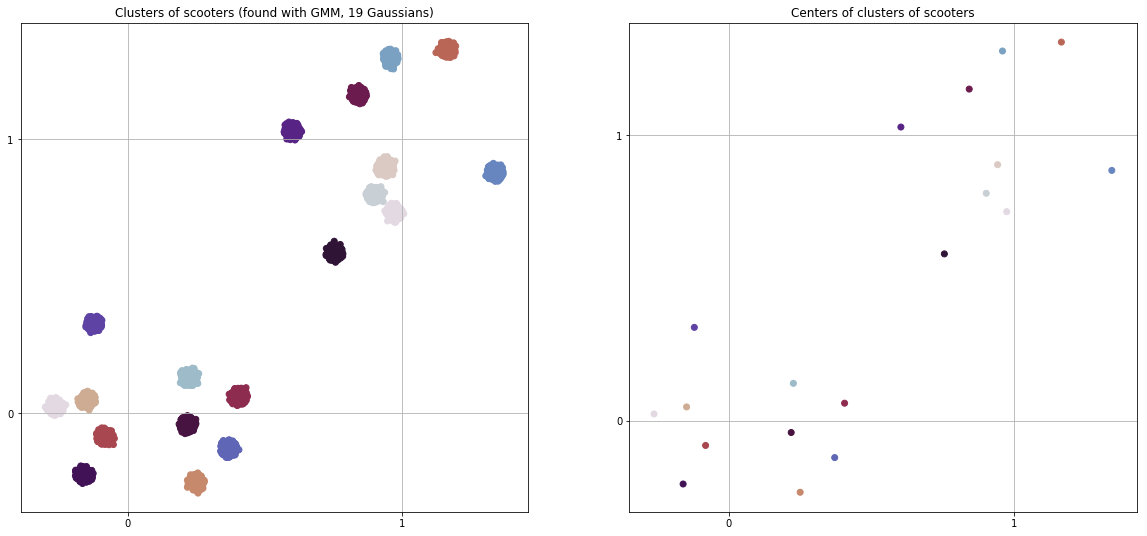

In [25]:
# Only considering location at this point
df_without_charge = df[["xcoordinate", "ycoordinate"]]

k = 19

# To have properly distinct colors
colormap = plt.cm.get_cmap("twilight", k)

clustering = GaussianMixture(k, "tied")
labels = clustering.fit_predict(df_without_charge)
df["cluster_label"] = labels

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9))

ax1.scatter(
    df_without_charge.xcoordinate,
    df_without_charge.ycoordinate,
    c=colormap(labels)
)
ax1.grid(True)
ax1.set_xticks(gridlines)
ax1.set_yticks(gridlines)
ax1.set_title("Clusters of scooters (found with GMM, 19 Gaussians)")
ax1.axis("equal")

ax2.scatter(
    clustering.means_[:,0],
    clustering.means_[:,1],
    marker="o",
    c=colormap(np.arange(19))
)
ax2.grid(True)
ax2.set_xticks(gridlines)
ax2.set_yticks(gridlines)
ax2.set_title("Centers of clusters of scooters")
ax2.axis("equal")

plt.show()

### What areas are most popular?
Here, I made a simple bar chart to show how widely different clusters vary in how many scooters they contain, and then I altered the size of the means of each cluster by scaling it according to the cluster's size. I ended up squaring the counts and dividing by the maximum to show the differences better, with hopes of showing higher priority areas more prominently. Of course, this makes the plot slightly misleading, because equal areas of the circles do not correspond to equal quantities of scooters, but this is just something nice that I made.

(-0.373742356051399,
 1.4563122328516973,
 -0.36054827417136925,
 1.4281798252687146)

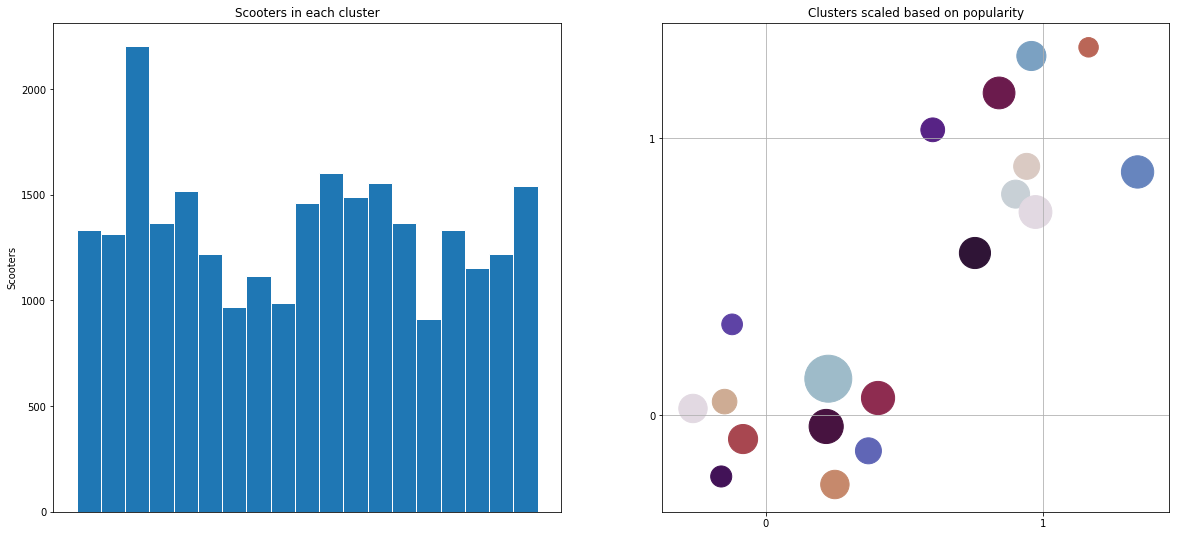

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9))

count_per_cluster, _, __ = ax1.hist(labels, bins=k, edgecolor="white")
ax1.set_ylabel("Scooters")
ax1.set_title("Scooters in each cluster")
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

scaled_count_per_cluster = np.array(count_per_cluster)**2/max(count_per_cluster)

ax2.scatter(
    clustering.means_[:,0],
    clustering.means_[:,1],
    marker="o",
    c=colormap(np.arange(k)),
    s=scaled_count_per_cluster
)
ax2.grid(True)
ax2.set_xticks(gridlines)
ax2.set_yticks(gridlines)
ax2.set_title("Clusters scaled based on popularity")
ax2.axis("equal")


### Exploratory analysis: common paths?
An interesting idea that I had was to look for the average charge of scooters in each cluster. If one cluster had a statistically significant average lower charge than the other clusters, then a logical conclusion would be that people are more often riding *to* that cluster than riding *from* it, meaning that it is a hot spot for local commerce.

It seems, however, that the average is roughly the same in each cluster. Not only that, but the proportion/distribution of charges is roughly the same in each cluster. There is not much of an interesting conclusion to draw from this, but it is worth noting!

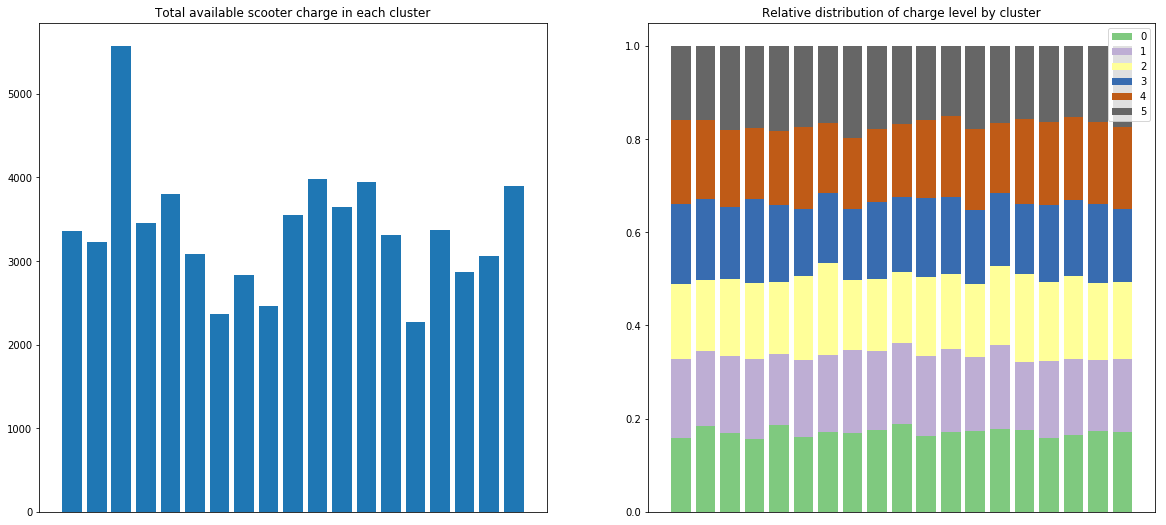

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9))

charges_per_cluster = np.array(
  [df.loc[df.cluster_label == cluster].power_level.sum() for cluster in range(k)]
)

ax1.bar(np.arange(k), charges_per_cluster)
ax1.set_title("Total available scooter charge in each cluster")
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

charge_needed_per_scooter = 5 - charges_per_cluster/count_per_cluster

charge_dist_per_cluster = np.array([
  [len(df[df.power_level == lvl].loc[df.cluster_label == cluster]) for lvl in range(6)]
  for cluster in range(k)
])
proportional_charge_per_cluster = np.array([
  [charge_count/sum(cluster_dist) for charge_count in cluster_dist]
  for cluster_dist in charge_dist_per_cluster
])

ax2.set_title("Relative distribution of charge level by cluster")
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
bottom = np.zeros(19)
colormap = plt.get_cmap("Accent", 6)
for charge_amt in range(6):
  ax2.bar(np.arange(k), proportional_charge_per_cluster[:,charge_amt], bottom=bottom, color=colormap(charge_amt))
  bottom += proportional_charge_per_cluster[:,charge_amt]
ax2.legend(np.arange(6))

### Naive solution: city charging tour with 19 stops
I am going to continue with the 19 clusters and propose a naive solution: the bus drives to the center of each group of scooters and charges all the scooters within the cluster before moving to the next one. Choosing the ordering of clusters is not so simple, because finding the shortest path that passes through all nodes in a graph is NP-hard, so I will assume that the bus travels $\frac{1}{4}$mi between each stop and can hold/charge as many scooters as there are in each cluster, and are collected/replaced in zero time.

It is assumed that the bus must leave the bus station and go to the city and go back to the bus station each day, so there is some travel time accounted for with that (plus the inter-station travel).

The number printed out is how many scooters need to be on the charger at all times if the single bus driver is operating at 100% efficiency for 24h straight, which is extremely unrealistic.

In [140]:
speed = 50
efficiency = 1.00
n_buses = 1

initial_dist = 38

dist_between_clusters = 0.25
cluster_travels = (k-1)/n_buses

travel_time = 2*(initial_dist + dist_between_clusters * cluster_travels) / speed

hours_for_charging = (24 - travel_time) * efficiency

total_charge_hours = (charge_needed_per_scooter * count_per_cluster).sum()

how_many_to_charge_at_a_time = total_charge_hours / (hours_for_charging * n_buses)
print(how_many_to_charge_at_a_time)

2882.107623318386


### Suggestion: more buses?
Here I explore the idea of varying driver efficiency and a greater quantity of buses with drivers. The 3D bar plot shows the relation between the number of buses (with $3n+1$ buses, $0 \leq n < 10$), driver efficiency, and how many scooters needed to be charged at once. I took out a rather likely slice of the 3D chart (50% efficiency) to show how quickly the work of each bus driver would go down with the addition of more drivers (it obeys an inverse relationship; doubling the quantity of drivers leads to half the amount of work per driver, because the total work needed is constant).

With 10 buses, if each driver operates at 50% efficiency (accounting for walking speed, placement onto bus, etc), each driver needs to collect just under 500 scooters per hour, or less than 9 per minute. This still seems like a lofty goal, but if more charging consultants sign up, the task will seem far more surmountable.

Text(0.5, 1.0, 'Scooters needing to be charged with 50% driver efficiency')

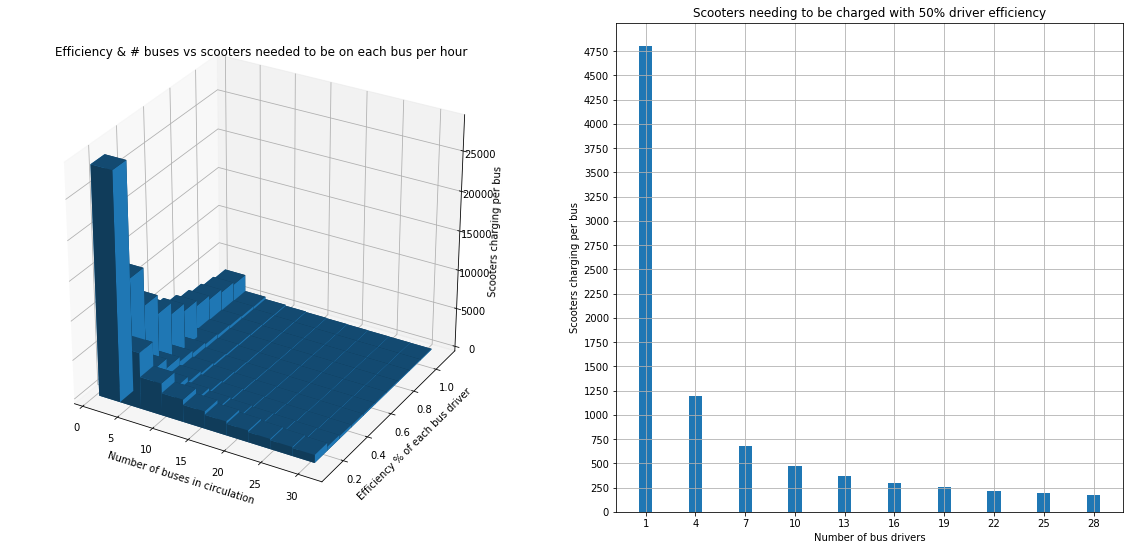

In [139]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20, 9))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

width = 3
depth = 0.1
_n_buses = width*np.arange(10) + 1
_efficiencies = 0.1*(1 + np.arange(10))

n_buses, efficiencies = np.meshgrid(_n_buses, _efficiencies)
n_buses, efficiencies = n_buses.ravel(), efficiencies.ravel()

speed = 50

initial_dist = 38

dist_between_clusters = 0.25
cluster_travels = (k-1)/n_buses

travel_time = 2*(initial_dist + dist_between_clusters * cluster_travels) / speed

hours_for_charging = (24 - travel_time) * efficiencies

total_charge_hours = (charge_needed_per_scooter * count_per_cluster).sum()

how_many_to_charge_at_a_time = total_charge_hours / (hours_for_charging * n_buses)

ax1.bar3d(n_buses, efficiencies, np.zeros_like(how_many_to_charge_at_a_time), width, depth, how_many_to_charge_at_a_time)
ax1.set_xlabel("Number of buses in circulation")
ax1.set_ylabel("Efficiency % of each bus driver")
ax1.set_zlabel("Scooters charging per bus")
ax1.set_title("Efficiency & # buses vs scooters needed to be on each bus per hour")

half_efficiency = how_many_to_charge_at_a_time[50:60]
ax2.bar(3*np.arange(10) + 1, half_efficiency)

ax2.set_xticks(3*np.arange(10) + 1)
ax2.set_yticks(np.arange(0,5000,250))

ax2.set_xlabel("Number of bus drivers")
ax2.set_ylabel("Scooters charging per bus")
ax2.grid(True)

ax2.set_title("Scooters needing to be charged with 50% driver efficiency")

## Conclusion: We need more charging options.
Whether we get more buses or resort to outsourcing charging as a side-hustle entered into via voluntary sign-ups, we need to have a better system for charging our scooters. Even if our one bus driver worked 24/7, at 100% efficiency, they would have to pick up two scooters every three seconds, and perfectly place them onto and remove them from the chargers.